<a href="https://colab.research.google.com/github/diegodeville16/KCGB-Complex/blob/main/Processing_and_VGGNET16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#MOUNT THE FOLDER
from google.colab import drive
import os
import json
import random
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path
import numpy as np

# Mount Google Drive
drive.mount('/content/drive')

# Set paths
images_path = '/content/drive/MyDrive/allphotos'  # Path to the folder containing images
json_file_path = '/content/drive/MyDrive/masks_and_labels.json'  # Path to the JSON file


Mounted at /content/drive


In [ ]:
# Load JSON data
with open(json_file_path, 'r') as file:
    annotations = json.load(file)

# Function to draw bounding box or polygon on an image
def draw_annotations(image, regions):
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for region in regions:
        shape_attrs = region['shape_attributes']
        species = region['region_attributes']['species']

        # Draw rectangle
        if shape_attrs['name'] == 'rect':
            x, y, width, height = shape_attrs['x'], shape_attrs['y'], shape_attrs['width'], shape_attrs['height']
            rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y - 10, species, color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

        # Draw polygon
        elif shape_attrs['name'] == 'polygon':
            all_points_x = shape_attrs['all_points_x']
            all_points_y = shape_attrs['all_points_y']
            polygon_points = list(zip(all_points_x, all_points_y))
            polygon = patches.Polygon(polygon_points, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(polygon)
            ax.text(all_points_x[0], all_points_y[0] - 10, species, color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()


In [ ]:
# Get list of image filenames
image_filenames = list(annotations.keys())

# Randomly select 5 images
selected_images = random.sample(image_filenames, 5)

# Load and display the selected images with annotations
for img_name in selected_images:
    # Full path to the image
    img_path = os.path.join(images_path, img_name)

    # Check if the image exists
    if not os.path.exists(img_path):
        print(f"Image {img_name} not found in the folder.")
        continue

    # Load the image using OpenCV
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib

    # Get the regions from the JSON file
    regions = annotations[img_name]['regions']

    # Draw and display annotations
    draw_annotations(image, regions)


#CREATE MASKS USING COORDINATES IN THE JSON FILE

In [ ]:


import json
import cv2
import numpy as np
import os

# Function to create a mask with a transparent background from bounding box coordinates
def create_mask_from_bbox(image, x, y, width, height):
    mask = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)  # Adding alpha channel
    mask[y:y + height, x:x + width, :3] = image[y:y + height, x:x + width]  # Keep the color
    mask[y:y + height, x:x + width, 3] = 255  # Set the alpha channel to opaque
    return mask

# Function to create a mask with a transparent background from polygon coordinates
def create_mask_from_polygon(image, all_points_x, all_points_y):
    mask = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)  # Adding alpha channel
    # Create an array of points (x, y) for the polygon
    points = np.array(list(zip(all_points_x, all_points_y)), np.int32)
    points = points.reshape((-1, 1, 2))
    # Create a blank mask for the polygon area
    mask_poly = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    cv2.fillPoly(mask_poly, [points], 255)
    # Mask out the region in the original image
    region = cv2.bitwise_and(image, image, mask=mask_poly)
    mask[:, :, :3] = region  # Keep the color
    # Set alpha channel to opaque where the mask is not black (i.e., the polygon area)
    mask[:, :, 3] = mask_poly  # Directly assign the mask as the alpha channel
    return mask

# Load JSON file
with open('/content/drive/MyDrive/masks_and_labels.json', 'r') as f:
    annotations = json.load(f)

# Set the input directory for images and output directory for masks
input_dir = '/content/drive/MyDrive/allphotos'
output_dir = '/content/drive/MyDrive/allphotos_masks'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loop through each image annotation
for image_name, image_info in annotations.items():
    # Load the image
    image_path = os.path.join(input_dir, image_name)
    image = cv2.imread(image_path)

    # If the image cannot be loaded, skip
    if image is None:
        print(f"Could not read {image_name}")
        continue

    # Loop through each region in the image (could be multiple bounding boxes or polygons)
    for region in image_info['regions']:
        shape_attributes = region['shape_attributes']

        if shape_attributes['name'] == 'rect':
            # Extract bounding box coordinates
            x = shape_attributes['x']
            y = shape_attributes['y']
            width = shape_attributes['width']
            height = shape_attributes['height']

            # Create mask from bounding box
            mask = create_mask_from_bbox(image, x, y, width, height)

        elif shape_attributes['name'] == 'polygon':
            # Extract polygon coordinates
            all_points_x = shape_attributes['all_points_x']
            all_points_y = shape_attributes['all_points_y']

            # Create mask from polygon
            mask = create_mask_from_polygon(image, all_points_x, all_points_y)

        # Save the mask image as a PNG file (which supports transparency)
        mask_filename = f"{os.path.splitext(image_name)[0]}_mask.png"
        cv2.imwrite(os.path.join(output_dir, mask_filename), mask)

    print(f"Processed {image_name}")


#RESIZE AND SORT IMAGES PER SPECIES

In [ ]:

import os
import cv2

# Set directories for input masks and output sorted folders
input_masks_dir = '/content/drive/MyDrive/allphotos_masks'
output_dir = '/content/drive/MyDrive/allphotos_masks_sorted'
resize_width = 256  # Set desired width for resized images
resize_height = 256  # Set desired height for resized images

# List of species names to sort
species_list = ["atrovirens", "carnatus", "caurinus", "chrysomelas"]

# Create directories for each species if they don't exist
for species in species_list:
    species_dir = os.path.join(output_dir, species)
    if not os.path.exists(species_dir):
        os.makedirs(species_dir)

# Loop through each mask image in the input directory
for mask_filename in os.listdir(input_masks_dir):
    # Check if the file is a valid image (you can add more extensions if needed)
    if mask_filename.endswith('.png'):
        # Extract species name from the filename (e.g., "atrovirens_1.png" -> "atrovirens")
        species_name = mask_filename.split('_')[0]

        if species_name in species_list:
            # Load the mask image
            mask_path = os.path.join(input_masks_dir, mask_filename)
            mask_image = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

            # Resize the mask image
            resized_mask = cv2.resize(mask_image, (resize_width, resize_height), interpolation=cv2.INTER_AREA)

            # Save the resized mask to the corresponding species folder
            output_species_dir = os.path.join(output_dir, species_name)
            output_mask_path = os.path.join(output_species_dir, mask_filename)
            cv2.imwrite(output_mask_path, resized_mask)

            print(f"Resized and saved: {output_mask_path}")

print("All masks have been resized and sorted.")


#PERFORM FIVE AUGMENTATIONS PER PHOTO

In [ ]:

import os
import cv2
import random
import numpy as np

# Directories for resized masks and output for augmented images
resized_images_dir = '/content/drive/MyDrive/allphotos_masks_sorted'
output_augmented_dir = '/content/drive/MyDrive/augmented_masks_sorted'

# List of species names
species_list = ["atrovirens", "carnatus", "caurinus", "chrysomelas"]

# Ensure directories exist for each species
for species in species_list:
    species_dir = os.path.join(output_augmented_dir, species)
    if not os.path.exists(species_dir):
        os.makedirs(species_dir)

# Augmentation Functions
def flip_image(image):
    return cv2.flip(image, 1)  # Horizontal flip

def rotate_image(image, angle=15):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image[:, :, :3], M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))
    alpha_channel = cv2.warpAffine(image[:, :, 3], M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return np.dstack([rotated, alpha_channel])

def random_crop(image, crop_size=(200, 200)):
    h, w = image.shape[:2]
    crop_h, crop_w = crop_size
    if w < crop_w or h < crop_h:
        return image  # Return original if crop size is too large

    start_x = random.randint(0, w - crop_w)
    start_y = random.randint(0, h - crop_h)
    cropped = image[start_y:start_y + crop_h, start_x:start_x + crop_w]

    # Resize back to original size
    return cv2.resize(cropped, (w, h), interpolation=cv2.INTER_LINEAR)

def blur_image(image, ksize=(5, 5)):
    blurred = cv2.GaussianBlur(image[:, :, :3], ksize, 0)
    return np.dstack([blurred, image[:, :, 3]])

def change_exposure(image, alpha=1.5, beta=20):
    adjusted = cv2.convertScaleAbs(image[:, :, :3], alpha=alpha, beta=beta)
    return np.dstack([adjusted, image[:, :, 3]])

# Loop through species directories to augment images
for species in species_list:
    species_input_dir = os.path.join(resized_images_dir, species)
    species_output_dir = os.path.join(output_augmented_dir, species)

    for image_filename in os.listdir(species_input_dir):
        if image_filename.endswith('.png'):
            # Load the image with alpha channel
            image_path = os.path.join(species_input_dir, image_filename)
            image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

            # Perform Augmentations
            augmented_images = [
                flip_image(image),                       # Augmentation 1: Flip
                rotate_image(image, angle=15),           # Augmentation 2: Rotate (e.g., 15 degrees)
                random_crop(image, crop_size=(200, 200)), # Augmentation 3: Random Crop
                blur_image(image),                       # Augmentation 4: Blur
                change_exposure(image, alpha=1.5, beta=20) # Augmentation 5: Exposure change
            ]

            # Save Augmented Images
            base_name = os.path.splitext(image_filename)[0]
            for i, aug_img in enumerate(augmented_images):
                augmented_filename = f"{base_name}_augmented{i + 1}.png"
                augmented_path = os.path.join(species_output_dir, augmented_filename)

                # Save augmented image with transparency
                cv2.imwrite(augmented_path, aug_img, [cv2.IMWRITE_PNG_COMPRESSION, 9])
                print(f"Saved: {augmented_path}")

print("All images have been augmented and saved with transparent backgrounds.")


Se han truncado las últimas 5000 líneas del flujo de salida.
Saved: /content/drive/MyDrive/augmented_masks_sorted/atrovirens/atrovirens_122_mask_augmented2.png
Saved: /content/drive/MyDrive/augmented_masks_sorted/atrovirens/atrovirens_122_mask_augmented3.png
Saved: /content/drive/MyDrive/augmented_masks_sorted/atrovirens/atrovirens_122_mask_augmented4.png
Saved: /content/drive/MyDrive/augmented_masks_sorted/atrovirens/atrovirens_122_mask_augmented5.png
Saved: /content/drive/MyDrive/augmented_masks_sorted/atrovirens/atrovirens_123_mask_augmented1.png
Saved: /content/drive/MyDrive/augmented_masks_sorted/atrovirens/atrovirens_123_mask_augmented2.png
Saved: /content/drive/MyDrive/augmented_masks_sorted/atrovirens/atrovirens_123_mask_augmented3.png
Saved: /content/drive/MyDrive/augmented_masks_sorted/atrovirens/atrovirens_123_mask_augmented4.png
Saved: /content/drive/MyDrive/augmented_masks_sorted/atrovirens/atrovirens_123_mask_augmented5.png
Saved: /content/drive/MyDrive/augmented_masks_so

#MERGE RESIZE AND AUGMENTED PHOTOS IN A DIRECTORY

In [ ]:

import os
import shutil

# Directories for resized and augmented images
resized_images_dir = '/content/drive/MyDrive/allphotos_masks_sorted'
augmented_images_dir = '/content/drive/MyDrive/augmented_masks_sorted'
merged_output_dir = '/content/drive/MyDrive/merged_augmented_masks_sorted'

# List of species names
species_list = ["atrovirens", "carnatus", "caurinus", "chrysomelas"]

# Ensure merged output directory exists
if not os.path.exists(merged_output_dir):
    os.makedirs(merged_output_dir)

# Create directories for each species in the merged output directory
for species in species_list:
    species_merged_dir = os.path.join(merged_output_dir, species)
    if not os.path.exists(species_merged_dir):
        os.makedirs(species_merged_dir)

# Function to copy images from source to destination
def copy_images(source_dir, destination_dir):
    for species in species_list:
        species_source_dir = os.path.join(source_dir, species)
        species_destination_dir = os.path.join(destination_dir, species)

        if os.path.exists(species_source_dir):
            for image_filename in os.listdir(species_source_dir):
                if image_filename.endswith('.png'):  # Only process PNG files
                    source_image_path = os.path.join(species_source_dir, image_filename)
                    destination_image_path = os.path.join(species_destination_dir, image_filename)

                    # Copy image to the destination
                    shutil.copyfile(source_image_path, destination_image_path)
                    print(f"Copied: {destination_image_path}")

# Copy images from both directories to the merged output
copy_images(resized_images_dir, merged_output_dir)
copy_images(augmented_images_dir, merged_output_dir)

print("All resized and augmented images have been merged and sorted by species.")


#PLOT RESIZE AND AUGMENTED PHOTOS


Chosen Resized Photo: carnatus_171_mask.png


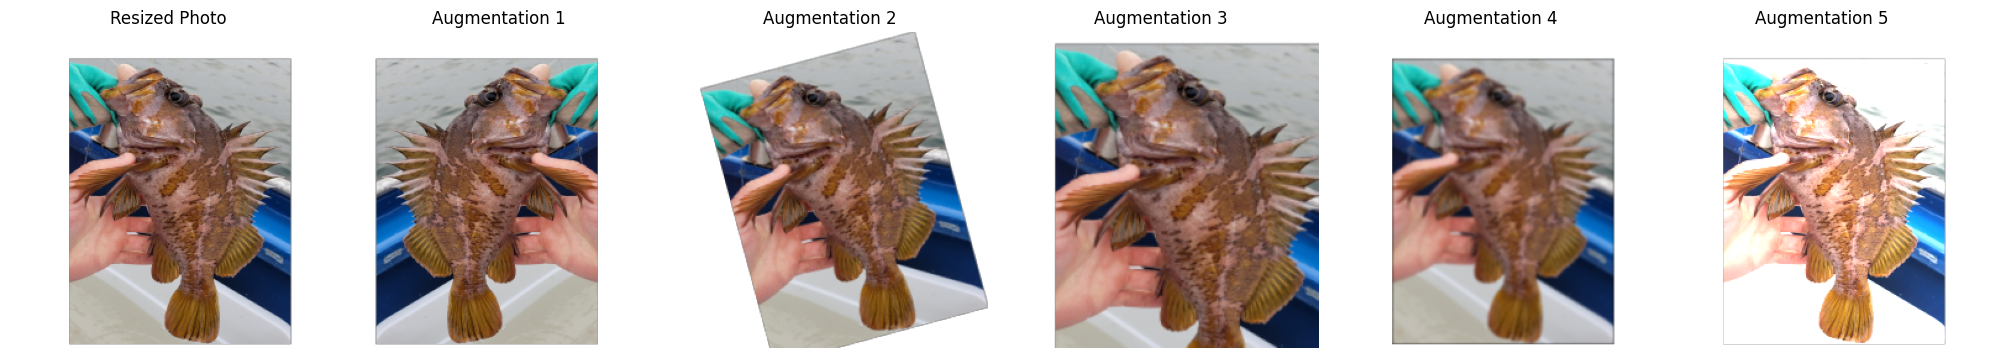

In [ ]:

import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Directory where merged images are stored
merged_images_dir = '/content/drive/MyDrive/merged_augmented_masks_sorted'

# List of species names
species_list = ["atrovirens", "carnatus", "caurinus", "chrysomelas"]

def plot_random_image_with_augmentations():
    # Choose a random species
    random_species = random.choice(species_list)
    species_dir = os.path.join(merged_images_dir, random_species)

    # Filter to find resized photos (exclude augmented ones)
    resized_photos = [img for img in os.listdir(species_dir) if img.endswith('.png') and 'augmented' not in img]

    # Randomly choose one resized photo
    chosen_photo = random.choice(resized_photos)

    # Display information about the chosen photo
    print(f"Chosen Resized Photo: {chosen_photo}")

    # Prepare to find augmentations
    base_name = os.path.splitext(chosen_photo)[0]  # Get base name without extension
    augmentation_files = [
        f"{base_name}_augmented1.png",
        f"{base_name}_augmented2.png",
        f"{base_name}_augmented3.png",
        f"{base_name}_augmented4.png",
        f"{base_name}_augmented5.png"
    ]

    # Load the chosen photo and its augmentations
    images = []
    try:
        # Load the resized photo
        resized_image_path = os.path.join(species_dir, chosen_photo)
        images.append(Image.open(resized_image_path).convert("RGBA"))

        # Load the augmentations
        for aug_file in augmentation_files:
            aug_image_path = os.path.join(species_dir, aug_file)
            if os.path.exists(aug_image_path):
                images.append(Image.open(aug_image_path).convert("RGBA"))
            else:
                print(f"Warning: {aug_file} not found.")
                return

        # Plot the images
        fig, axes = plt.subplots(1, 6, figsize=(20, 5))
        titles = ["Resized Photo"] + [f"Augmentation {i+1}" for i in range(5)]

        for ax, img, title in zip(axes, images, titles):
            ax.imshow(img)
            ax.set_title(title)
            ax.axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error loading images: {e}")

# Run the function to display random resized photo with augmentations
plot_random_image_with_augmentations()


#NORMALIZED RESIZED AND AUGMENTED PHOTOS

In [ ]:

import os
from PIL import Image
import numpy as np

# Directory where merged images are stored
merged_images_dir = '/content/drive/MyDrive/merged_augmented_masks_sorted'
normalized_images_dir = '/content/drive/MyDrive/normalized_resized_augmented_masks_sorted'

# List of species names
species_list = ["atrovirens", "carnatus", "caurinus", "chrysomelas"]

def normalize_and_save_images():
    # Create the directory for normalized images if it doesn't exist
    os.makedirs(normalized_images_dir, exist_ok=True)

    for species in species_list:
        species_dir = os.path.join(merged_images_dir, species)
        normalized_species_dir = os.path.join(normalized_images_dir, species)

        # Create the species directory for normalized images
        os.makedirs(normalized_species_dir, exist_ok=True)

        # List all images in the species directory
        for img_file in os.listdir(species_dir):
            if img_file.endswith('.png'):
                try:
                    # Load the image
                    img_path = os.path.join(species_dir, img_file)
                    image = Image.open(img_path).convert("RGBA")

                    # Convert image to numpy array and normalize
                    img_array = np.array(image).astype(np.float32)
                    img_array[..., :3] /= 255.0  # Normalize RGB channels
                    img_array[..., 3] /= 255.0    # Normalize alpha channel

                    # Convert back to uint8 format, preserving transparency
                    normalized_image = (img_array * 255).astype(np.uint8)
                    normalized_image_pil = Image.fromarray(normalized_image, 'RGBA')

                    # Save the normalized image
                    normalized_image_path = os.path.join(normalized_species_dir, img_file)
                    normalized_image_pil.save(normalized_image_path, format='PNG')

                    print(f"Saved normalized image: {normalized_image_path}")

                except Exception as e:
                    print(f"Error processing {img_file}: {e}")

# Run the normalization function
normalize_and_save_images()


Se han truncado las últimas 5000 líneas del flujo de salida.
Saved normalized image: /content/drive/MyDrive/normalized_resized_augmented_masks_sorted/carnatus/carnatus_94_mask_augmented3.png
Saved normalized image: /content/drive/MyDrive/normalized_resized_augmented_masks_sorted/carnatus/carnatus_94_mask_augmented4.png
Saved normalized image: /content/drive/MyDrive/normalized_resized_augmented_masks_sorted/carnatus/carnatus_94_mask_augmented5.png
Saved normalized image: /content/drive/MyDrive/normalized_resized_augmented_masks_sorted/carnatus/carnatus_95_mask_augmented1.png
Saved normalized image: /content/drive/MyDrive/normalized_resized_augmented_masks_sorted/carnatus/carnatus_95_mask_augmented2.png
Saved normalized image: /content/drive/MyDrive/normalized_resized_augmented_masks_sorted/carnatus/carnatus_95_mask_augmented3.png
Saved normalized image: /content/drive/MyDrive/normalized_resized_augmented_masks_sorted/carnatus/carnatus_95_mask_augmented4.png
Saved normalized image: /cont

CRREATE TRIAL AND FINAL SETS OF IMAGES

In [ ]:
import os
import shutil
import random

# Set the base directory containing the species folders
base_dir = '/content/drive/MyDrive/normalized_resized_augmented_masks_sorted'  # Update this path to your images directory

# Specify the names and paths for training and testing directories
train_dir = '/content/drive/MyDrive/train_masks_6000'  # Update this path for train directory
test_dir = '/content/drive/MyDrive/test_masks_6000'    # Update this path for test directory

# Create train and test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Number of images for training and testing
train_size = 1200 #Number of masks per species
test_size = 300 #Number of masks per species

# Process each species
species = ['atrovirens', 'chrysomelas', 'caurinus', 'carnatus']

for sp in species:
    sp_dir = os.path.join(base_dir, sp)
    images = [f for f in os.listdir(sp_dir) if os.path.isfile(os.path.join(sp_dir, f))]

    # Shuffle and split images
    random.shuffle(images)

    # Select images for training and testing
    train_images = images[:train_size]
    test_images = images[train_size:train_size + test_size]

    # Create subdirectories for train and test
    os.makedirs(os.path.join(train_dir, sp), exist_ok=True)
    os.makedirs(os.path.join(test_dir, sp), exist_ok=True)

    # Move images to respective directories
    for img in train_images:
        shutil.move(os.path.join(sp_dir, img), os.path.join(train_dir, sp, img))

    for img in test_images:
        shutil.move(os.path.join(sp_dir, img), os.path.join(test_dir, sp, img))


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support, accuracy_score, top_k_accuracy_score, cohen_kappa_score
from tensorflow.keras.utils import plot_model
import itertools




GENERATE THE TRAIN, TEST, AND VALIDATION BACTHES FROM THE DATASETS

In [ ]:
# Set parameters
img_height, img_width = 224, 224
batch_size = 64

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use 20% of the training data for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Training generator
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/train_masks_6000',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/train_masks_6000',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation',
    shuffle=True
)

# Testing generator
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/test_masks_6000',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)


Found 3840 images belonging to 4 classes.
Found 960 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.


DOWNLOAD THE VGG16NET, FREEZE THE FIRST LAYERS, AND SET THE INITIAL LEARNING RATE

In [ ]:
#THIS ONE INCLUDES A SECTION TO CHANGE THE INITIAL LEARNING RATE
# Load the VGG16 model, excluding the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

# Set the initial learning rate
initial_learning_rate = 0.0010  # Change this value as needed

# Compile the model with the Adam optimizer and the specified learning rate
model.compile(optimizer=Adam(learning_rate=initial_learning_rate),  # Set the learning rate here
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


TRAIN AND USE THE VGG16NET. SET THE FOLLOWING PARAMETERS: PATIENCE EARLY STOPPING, PATIENCE REDUCE LEARNING, AND EPOCHS. THE OUTPUT CORRESPONDS TO ONE OF THE LONGEST RUNS

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience= 10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

# Fit the model
history = model.fit(
    train_generator,
    epochs= 50,  # Adjust the number of epochs as needed
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 40s 569ms/step - accuracy: 0.2785 - loss: 2.2753 - val_accuracy: 0.3979 - val_loss: 1.3588 - learning_rate: 0.0010
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 542ms/step - accuracy: 0.3584 - loss: 1.2706 - val_accuracy: 0.4115 - val_loss: 1.2198 - learning_rate: 0.0010
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 35s 530ms/step - accuracy: 0.4436 - loss: 1.1395 - val_accuracy: 0.4719 - val_loss: 1.1627 - learning_rate: 0.0010
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 35s 538ms/step - accuracy: 0.4771 - loss: 1.0873 - val_accuracy: 0.4448 - val_loss: 1.1356 - learning_rate: 0.0010
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 533ms/step - accuracy: 0.5096 - loss: 1.0300 - val_accuracy: 0.4698 - val_loss: 1.1420 - learning_rate: 0.0010
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 540ms/step - accuracy: 0.5262 - loss: 0.9927 - val_accuracy: 0.5896 - val_loss: 1.0582 - learning_rate: 0.0010
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 549ms/step - accuracy: 0.5668 - loss: 0.9717 - val_

EVALUATE THE MODEL WITH LOSS FUNCTON AND ACCURACY

In [ ]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 489ms/step - accuracy: 0.8186 - loss: 0.4970
Test Loss: 0.6092
Test Accuracy: 0.8258


# Learning Curves: Accuracy and Loss over epochs

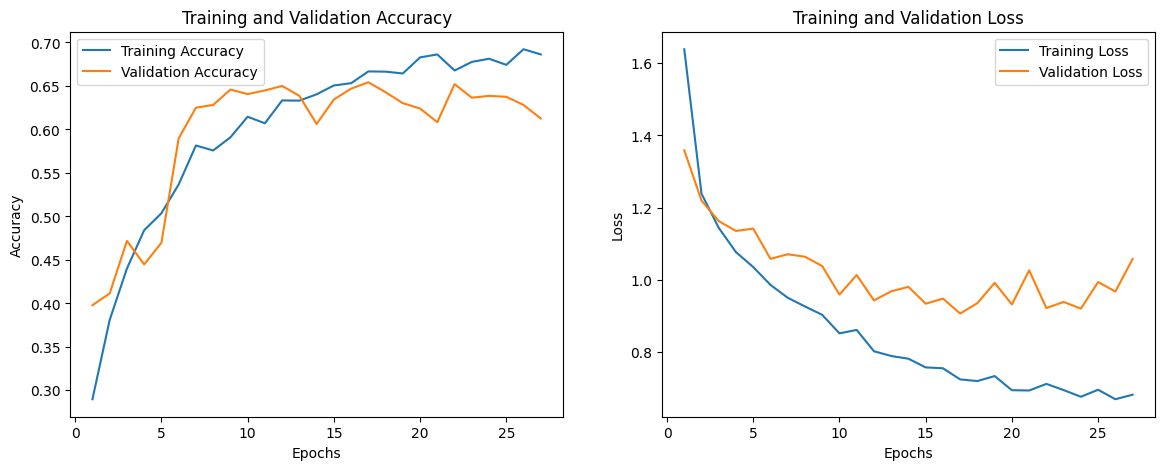

In [ ]:
# Learning Curves: Accuracy and Loss over epochs
def plot_learning_curves(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function
plot_learning_curves(history)


CONFUSION MATRIX

19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 491ms/step


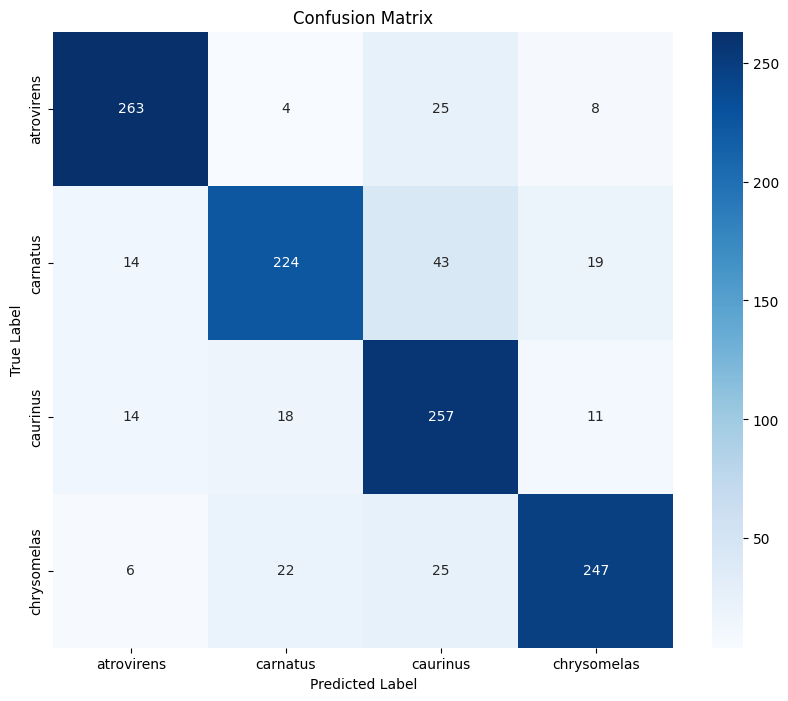

              precision    recall  f1-score   support

  atrovirens       0.89      0.88      0.88       300
    carnatus       0.84      0.75      0.79       300
    caurinus       0.73      0.86      0.79       300
 chrysomelas       0.87      0.82      0.84       300

    accuracy                           0.83      1200
   macro avg       0.83      0.83      0.83      1200
weighted avg       0.83      0.83      0.83      1200



In [ ]:
# Get predictions
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(test_generator.class_indices.keys()), yticklabels=list(test_generator.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))


ROC CURVES AND AUCs

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 433ms/step


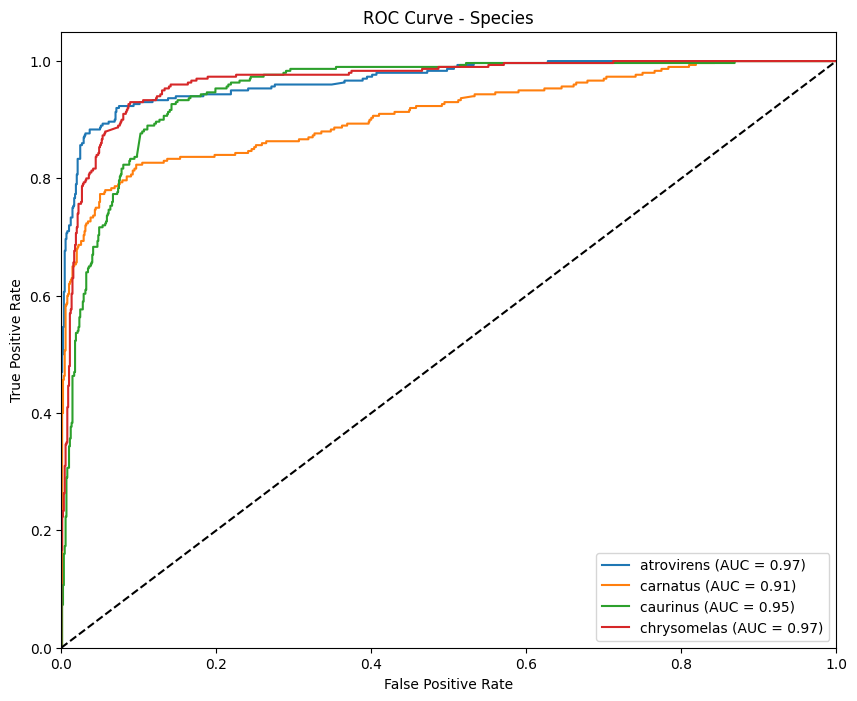

In [ ]:
from sklearn.preprocessing import label_binarize

# Binarize the output
n_classes = len(test_generator.class_indices)
y_true_bin = label_binarize(y_true, classes=range(n_classes))
y_pred_prob = model.predict(test_generator)

# Get the species names based on the class indices
species_names = list(test_generator.class_indices.keys())

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{species_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Species')
plt.legend(loc="lower right")
plt.show()

Top-K Accuracy Scores

In [ ]:
# Assuming y_pred_prob contains the predicted probabilities for each class,
# and y_true contains the true class labels.

# Function to calculate top-K accuracy
def top_k_accuracy_score(y_true, y_pred_prob, k=3):
    # Convert predictions to top-k indices
    top_k_preds = np.argsort(y_pred_prob, axis=1)[:, -k:]
    # Check if the true labels are within the top-k predictions
    matches = [1 if y_true[i] in top_k_preds[i] else 0 for i in range(len(y_true))]
    return np.mean(matches)

# Top-1 accuracy (equivalent to standard accuracy)
top_1_acc = accuracy_score(y_true, np.argmax(y_pred_prob, axis=1))
print(f"Top-1 Accuracy: {top_1_acc:.4f}")

# Top-2 accuracy
top_2_acc = top_k_accuracy_score(y_true, y_pred_prob, k=2)
print(f"Top-2 Accuracy: {top_2_acc:.4f}")

# Top-3 accuracy
top_3_acc = top_k_accuracy_score(y_true, y_pred_prob, k=3)
print(f"Top-3 Accuracy: {top_3_acc:.4f}")

# Cohen's Kappa Score
kappa_score = cohen_kappa_score(y_true, np.argmax(y_pred_prob, axis=1))
print(f"Cohen's Kappa Score: {kappa_score:.4f}")

Top-1 Accuracy: 0.8258
Top-2 Accuracy: 0.9400
Top-3 Accuracy: 0.9833
Cohen's Kappa Score: 0.7678
